# Controlled Abstention Networks (CAN) for classification tasks
* authors: Elizabeth A. Barnes, Randal J. Barnes
* published in Barnes, Elizabeth A. and Randal J. Barnes: Controlled abstention neural networks for identifying skillful predictions for classification problems, submitted to JAMES, 04/2021.
* code updated: April 16, 2021

In [1]:
import time
import sys
import glob
import os

from sklearn import preprocessing
import tensorflow as tf

import numpy as np

import gameboard as gboard
import metrics
import abstentionloss
import network
import gameboard_plots as plots

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
tf.print(f"sys.version = {sys.version}", output_stream=sys.stdout)
tf.print(f"tf.version.VERSION = {tf.version.VERSION}", output_stream=sys.stdout)

sys.version = 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
tf.version.VERSION = 2.4.1


## Initialize and define functions

In [2]:
checkpointDir = 'checkpoints/'

#---------------------------------------------------
# Initialize random seeds
NP_SEED = 99
np.random.seed(NP_SEED)
tf.random.set_seed(99)

In [3]:
#---------------------------------------------------
def prep_data():
    # Process the data, create onehotencoding
    
    xmean = np.mean(X_train[:]) #standardize here
    xstd = np.std(X_train[:])
    X_train_std = (X_train-xmean)/xstd
    X_val_std = (X_val-xmean)/xstd

    enc = preprocessing.OneHotEncoder()
    enc.fit(np.append(y_train, NLABEL)[:,np.newaxis])
    onehotlabels = enc.transform(np.array(y_train).reshape(-1, 1)).toarray()
    onehotlabels_val = enc.transform(np.array(y_val).reshape(-1, 1)).toarray()

    return (X_train_std, X_val_std, onehotlabels, onehotlabels_val, xmean, xstd)

#---------------------------------------------------
def make_model(loss_str = 'DNN', updater_str='Colorado', setpoint=.5, spinup_epochs=10, nupd=10):
    # Define and train the model
    
    tf.keras.backend.clear_session()
    if(loss_str == 'DNN'):
        model = network.defineNN(HIDDENS, input_shape=X_train_std.shape[1], output_shape=NLABEL, ridge_penalty=RIDGE, act_fun='relu', network_seed=NETWORK_SEED)
        loss_function = tf.keras.losses.CategoricalCrossentropy()
        model.compile(
            optimizer=tf.keras.optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                metrics.AbstentionFraction(NLABEL),
                metrics.PredictionAccuracy(NLABEL)
            ]
        )        
    else:
        model = network.defineNN(HIDDENS, input_shape=X_train_std.shape[1], output_shape=NLABEL+1, ridge_penalty=RIDGE, act_fun='relu', network_seed=NETWORK_SEED)
        updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                       alpha_init=.5, 
                                                       length=nupd)
        loss_function = getattr(abstentionloss, loss_str)(updater=updater,
                                                          spinup_epochs=spinup_epochs)
        model.compile(
            optimizer=tf.keras.optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                alpha_value,
                metrics.AbstentionFraction(NLABEL),
                metrics.PredictionLoss(NLABEL),
                metrics.PredictionAccuracy(NLABEL)
            ]
        )        
        
    # model.summary()
        
    return model, loss_function

#---------------------------------------------------
def alpha_value(y_true,y_pred):
    return loss_function.updater.alpha

#---------------------------------------------------
def scheduler(epoch, lr):
    if epoch < lr_epoch_bound:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

#---------------------------------------------------
class EarlyStoppingCAN(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingCAN, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as zero.
        self.best = 0.
        self.best_epoch = np.Inf
        # initialize best_weights to non-trained model
        self.best_weights = self.model.get_weights()
        

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_prediction_accuracy")
        if np.greater(current, self.best):
            abstention_error = np.abs(logs.get("val_abstention_fraction") - setpoint)
            if np.less(abstention_error,.1):
                self.best = current
                self.wait = 0
                # Record the best weights if current results is better (greater).
                self.best_weights = self.model.get_weights()
                self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Early stopping, setting to best_epoch = " + str(self.best_epoch + 1))    


## Make the data

X_train shape = (5744, 2)


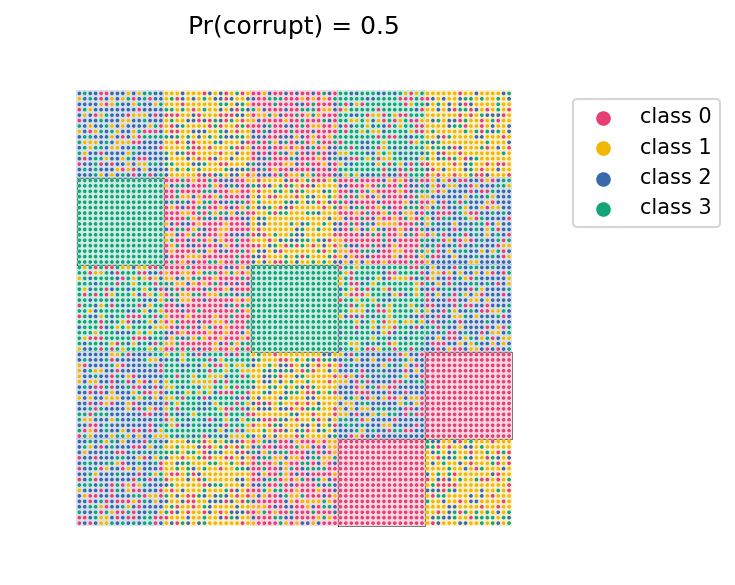

In [4]:
example_name = 'gameboard'

NROW = 80#128                             # number of grid rows
NCOL = 80#128                             # number of grid columns

NRANK = 5                              # number of game board rows
NFILE = 5                              # number of game board columns

NLABEL = 4                             # number of unique labels

NTRANQUIL = 4                          # number of tranquil (not noisy) gameboard cells
NNOISY = NRANK*NFILE - NTRANQUIL       # number of noisy cells

PR_VALIDATION = 0.10                   # probability that a pixel is recruited for validation
PR_MISLABEL = .5                     # probability that pixels in noisy gameboard cells are mislabeled

# make the data
gameboard = gboard.Gameboard(NROW, NCOL, NRANK, NFILE, NLABEL, NTRANQUIL, PR_VALIDATION, PR_MISLABEL)
X_all, y_all, X_train, y_train, X_val, y_val = gameboard.generate()
print('X_train shape = ' + str(np.shape(X_train)))

# Show the gameboard data
plt.figure(figsize=(5, 4))
plots.plot_data(X_all, y_all, gameboard, title_str='Pr(corrupt) = ' + str(PR_MISLABEL))
plt.tight_layout()
plt.show()

# Pre-process the gameboard data
X_train_std, X_val_std, onehotlabels, onehotlabels_val, xmean, xstd = prep_data()            

# Train the model

--> Training a CAN...
Restoring model weights from the end of the best epoch.
Early stopping, setting to best_epoch = 119
Elapsed time during fit = 27.51 seconds



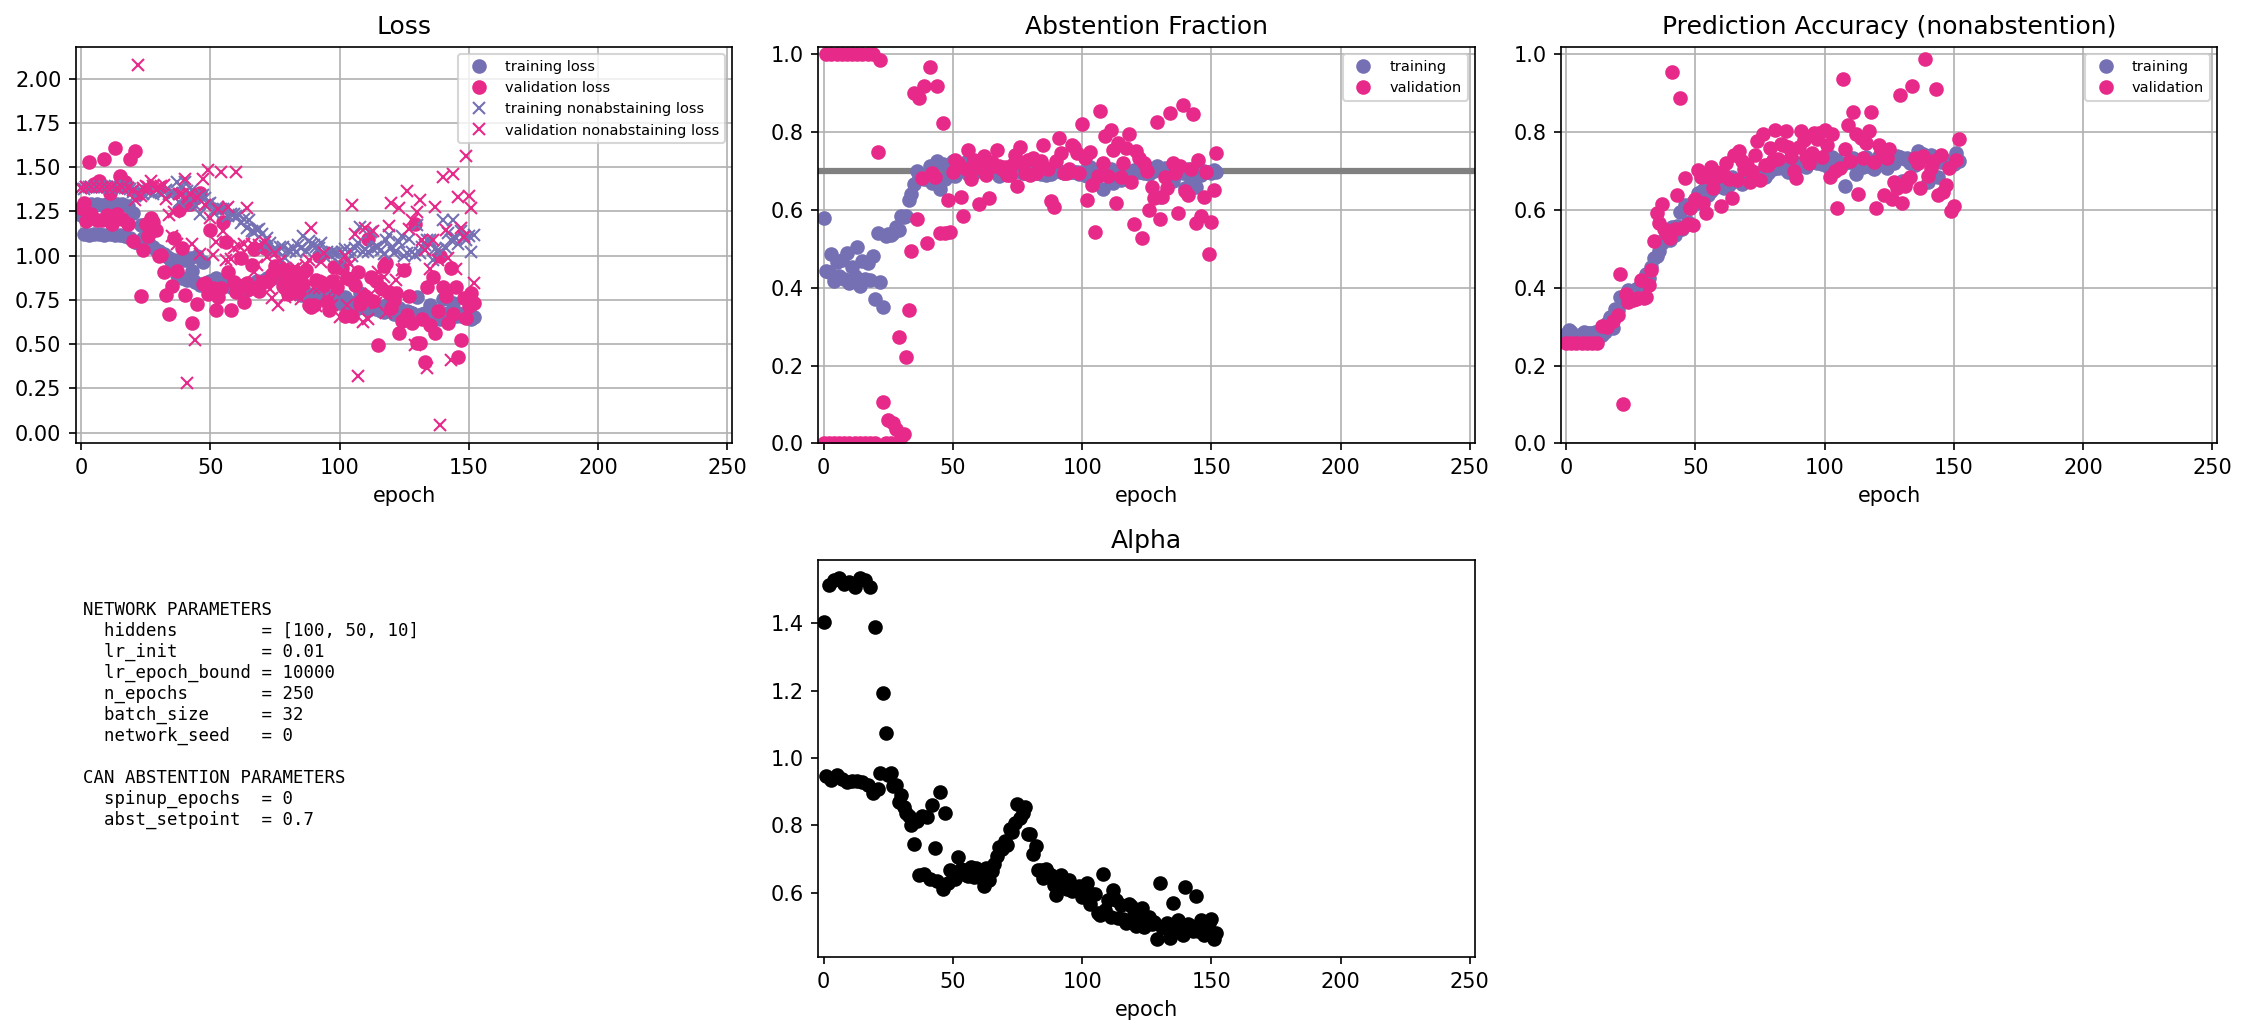

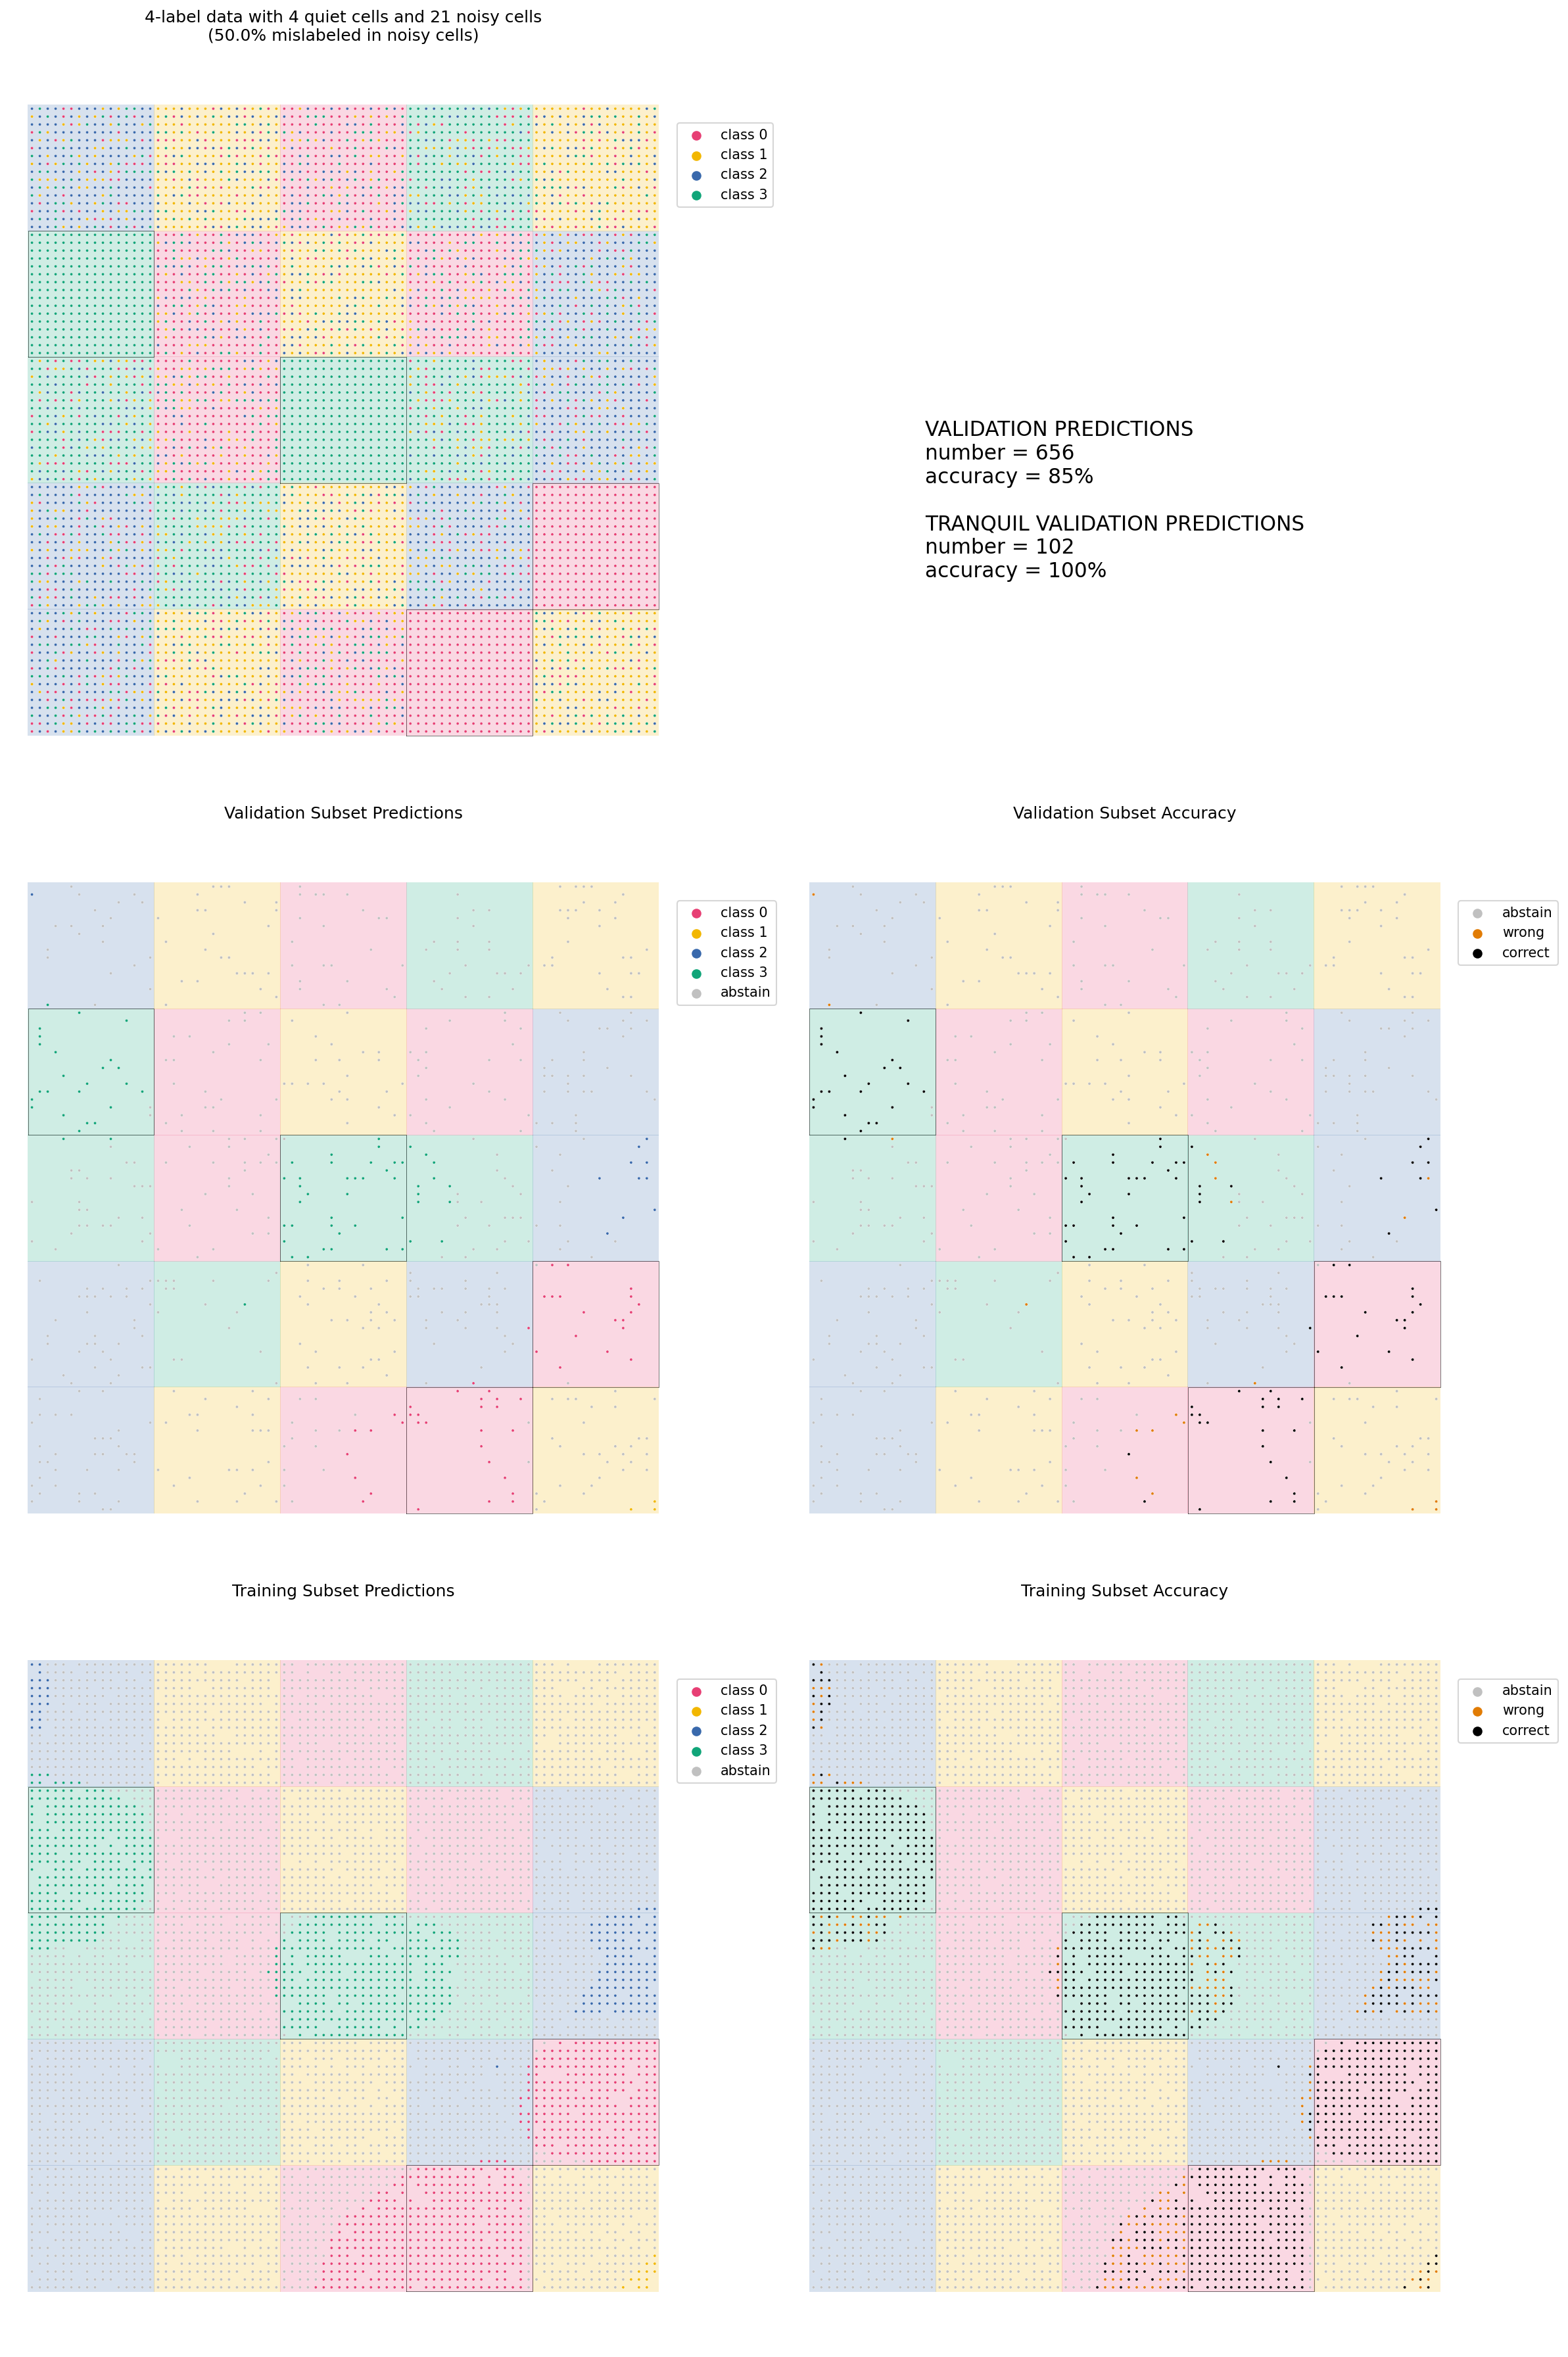

Validation = Counter({-1: 522, 1: 114, 0: 20})
Training = Counter({-1: 4477, 1: 1065, 0: 202})


In [5]:
#---------------------
# Set parameters
LOSS = 'NotWrongLoss'
UPDATER = 'Colorado'
NUPD = 6
HIDDENS = [100,50,10]
SPINUP_EPOCHS = 0
BATCH_SIZE = 32
LR_INIT = 0.01
N_EPOCHS = 250
LR_EPOCH_BOUND = 10000
RIDGE = 0.
#---------------------
NETWORK_SEED = 0
network_type = 'CAN' # 'CAN' or 'DNN'
setpoint = .7
#---------------------


#-------------------------------
# Get the model
tf.keras.backend.clear_session()

# define the model, loss function and callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpointDir + 'model_gameboard' + '_epoch{epoch:03d}.h5', 
    verbose=0, 
    save_weights_only=True,
)

if(network_type=='CAN'):
    print('--> Training a CAN...')    
    es_can_callback = EarlyStoppingCAN(patience=30)            
    model, loss_function = make_model(loss_str = LOSS, 
                                      updater_str=UPDATER, 
                                      setpoint=setpoint, 
                                      spinup_epochs=SPINUP_EPOCHS,
                                      nupd=NUPD)
    callbacks = [abstentionloss.AlphaUpdaterCallback(), es_can_callback, cp_callback]            

elif(network_type=='DNN'):
    print('--> Training a standard DNN...')
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_prediction_accuracy', 
                                                   patience=30, 
                                                   mode='max', 
                                                   restore_best_weights=True, 
                                                   verbose=1)                    
    model, loss_function = make_model(loss_str = 'DNN')
    callbacks = [es_callback, cp_callback]
    

#-------------------------------
# Remake onehotencoding for whether CAN or DNN
hotlabels = onehotlabels[:,:model.output_shape[-1]] # strip off abstention class if using the DNN
hotlabels_val = onehotlabels_val[:,:model.output_shape[-1]] # strip off abstention class if using the DNN

#-------------------------------
# Train the model
start_time = time.time()

history = model.fit(
    X_train_std,
    hotlabels,
    validation_data=(X_val_std, hotlabels_val),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    shuffle=True,
    verbose=0,
    callbacks=callbacks
)

stop_time = time.time()
tf.print(f"Elapsed time during fit = {stop_time - start_time:.2f} seconds\n")

model.save_weights('saved_models/model_gameboard.h5')
for f in glob.glob(checkpointDir + 'model_gameboard' + '_epoch*.h5'):
    os.remove(f)        


#-------------------------------
# Plot the gameboard results
plots.plot_results(
    history,
    exp_info=(LOSS, N_EPOCHS, setpoint, SPINUP_EPOCHS, HIDDENS, LR_INIT, LR_EPOCH_BOUND, BATCH_SIZE, NETWORK_SEED),
    showplot=True
)

# plot final predictions
y_train_pred = model.predict(X_train_std)
y_val_pred = model.predict(X_val_std)

plots.plot_predictions(
    data=(X_all, y_all, X_train, y_train, X_val, y_val, y_train_pred, y_val_pred, onehotlabels_val, NLABEL),
    gameboard=gameboard,
    showplot=True
)        

